In [1]:
import torch
from IPython.core.magic_arguments import argument
from torch.utils.tensorboard import SummaryWriter
import os
from IPython.display import display
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error
import PIL
from PIL import Image
from torchvision import datasets, transforms , models
from torch.utils.data import DataLoader , Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
writer = SummaryWriter()
# import warnings
# warnings.filterwarnings("ignore")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 0
print(DEVICE)

0


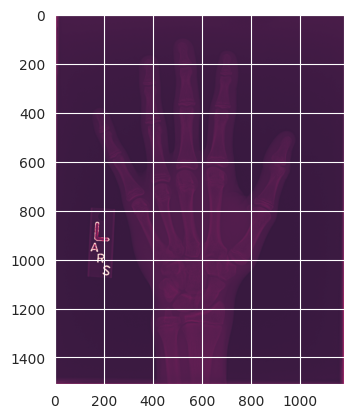

In [25]:
root_path = './../tf_venv/bone_age/archive/'
images_path = './../tf_venv/bone_age/archive/boneage-training-dataset/boneage-training-dataset/'
plt.imshow(plt.imread(images_path + "2756.png"))


In [3]:
csv_df = pd.read_csv(root_path + "/boneage-training-dataset.csv")
print(csv_df.head())

     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False


In [4]:
csv_df["male"] = csv_df['male'].apply(lambda x: 1 if x else 0)
csv_df['img_path'] = csv_df['id'].apply(lambda x: images_path + str(x) + ".png")
csv_df.head()

,id,boneage,male,img_path
0,1377,180,0,./../tf_venv/bone_age/archive/boneage-training...
1,1378,12,0,./../tf_venv/bone_age/archive/boneage-training...
2,1379,94,0,./../tf_venv/bone_age/archive/boneage-training...
3,1380,120,1,./../tf_venv/bone_age/archive/boneage-training...
4,1381,82,0,./../tf_venv/bone_age/archive/boneage-training...


In [5]:
transform = transforms.Compose([
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])
augmentations = transforms.Compose([
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2)
])

In [6]:
class CustomDataset(Dataset):
    def __init__(self, df, transform = None ,augmentations = None):
        super(CustomDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.augmentations = augmentations
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img,gender,label = self.df.iloc[idx]["img_path"],self.df.iloc[idx]["male"],self.df.iloc[idx]["boneage"]
        img = Image.open(img).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.augmentations is not None:
            img = self.augmentations(img)

        # Applying target transformations if specified
        gender = torch.tensor(gender,dtype=torch.float32)
        label = torch.tensor(label,dtype=torch.float32)
        # Returning image and target label
        return img, gender, label

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_layers = models.resnet18(pretrained=True)
        self.conv_layers.fc = nn.Identity()
        self.fc_layers = nn.Sequential(
            nn.Linear(512 + 16, 512), # 512 : res18 or 2048 : res50
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        self.fc_gender = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )
    def forward(self, img, gender):
        # print(img.shape,gender.shape)
        img_x = self.conv_layers(img)
        gender_x = self.fc_gender(gender)

        concatenated = torch.cat((img_x, gender_x), dim=1)
        y_hat = self.fc_layers(concatenated)
        return y_hat.squeeze()


In [8]:
batch_size = 64
train_data, temp_data = train_test_split(csv_df,test_size=0.2)
test_data, eval_data = train_test_split(temp_data,test_size=0.5)
print(f"train data size: {len(train_data)} , test data size: {len(test_data)} , val data size: {len(eval_data)}")
train_dataset = CustomDataset(train_data, transform=transform,augmentations=augmentations)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

eval_dataset = CustomDataset(eval_data, transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataset = CustomDataset(test_data, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

train data size: 10088 , test data size: 1261 , val data size: 1262


In [9]:
# Hyperparameters
num_epochs = 20
learning_rate = 0.0003

model = Model().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4,betas=(0.9, 0.999))

/home/behrazwslubuntu/pytorch_venv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/behrazwslubuntu/pytorch_venv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def evaluate_model(model, eval_dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for img_x, genders_x, y in tqdm(eval_dataloader):

            img_x = img_x.to(device)
            genders_x = genders_x.to(device)
            genders_x = genders_x.view(-1, 1)
            y = y.to(device)

            y_hat = model(img_x, genders_x)
            loss = criterion(y_hat, y)
            running_loss += loss.item() * img_x.size(0)

    eval_loss = running_loss / len(eval_dataloader.dataset)
    return eval_loss


In [11]:
class History:
    def __init__(self):
        self.history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    def update(self, train_loss, val_loss, train_acc=None, val_acc=None):
        self.history["train_loss"].append(train_loss)
        self.history["val_loss"].append(val_loss)
        if train_acc is not None:
            self.history["train_acc"].append(train_acc)
        if val_acc is not None:
            self.history["val_acc"].append(val_acc)

    def get(self):
        return self.history


In [12]:
history = History()
def train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, device, num_epochs=10, patience = 10):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=3)
    model.train()
    best_val_loss = float("inf")
    counter = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for img_x, genders_x, y in tqdm(train_dataloader):

            img_x = img_x.to(device)
            genders_x = genders_x.to(device)
            genders_x = genders_x.view(-1, 1)
            y = y.to(device)
            # print(img_x.shape,genders_x.shape)
            optimizer.zero_grad()
            y_hat = model(img_x, genders_x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img_x.size(0)

        epoch_train_loss = running_loss / len(train_dataloader.dataset)

        # Validation phase
        val_loss = evaluate_model(model, eval_dataloader, criterion, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f"./models/bone_age/model_best_augment.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break
        history.update(epoch_train_loss, val_loss)
        scheduler.step(val_loss)  # Monitors validation loss
        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']}')




In [13]:
train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, DEVICE, num_epochs)

100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 1/20, Train Loss: 2825.3465, Val Loss: 381.9905, LR: 0.0003


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


Epoch 2/20, Train Loss: 460.3511, Val Loss: 313.3714, LR: 0.0003


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Epoch 3/20, Train Loss: 412.3545, Val Loss: 165.1331, LR: 0.0003


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Epoch 4/20, Train Loss: 384.8457, Val Loss: 287.3152, LR: 0.0003


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


Epoch 5/20, Train Loss: 349.1902, Val Loss: 328.2343, LR: 0.0003


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


Epoch 6/20, Train Loss: 335.8236, Val Loss: 150.5537, LR: 0.0003


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Epoch 7/20, Train Loss: 331.7939, Val Loss: 131.0702, LR: 0.0003


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Epoch 8/20, Train Loss: 342.7785, Val Loss: 171.4921, LR: 0.0003


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Epoch 9/20, Train Loss: 323.1232, Val Loss: 286.2888, LR: 0.0003


100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


Epoch 10/20, Train Loss: 326.5486, Val Loss: 159.1399, LR: 0.0003


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 11/20, Train Loss: 302.2031, Val Loss: 138.5623, LR: 0.00027


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Epoch 12/20, Train Loss: 298.7739, Val Loss: 155.9491, LR: 0.00027


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 13/20, Train Loss: 301.0814, Val Loss: 153.8052, LR: 0.00027


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Epoch 14/20, Train Loss: 293.6690, Val Loss: 148.8821, LR: 0.00027


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Epoch 15/20, Train Loss: 295.5007, Val Loss: 105.6267, LR: 0.00027


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Epoch 16/20, Train Loss: 289.4018, Val Loss: 120.8617, LR: 0.00027


100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


Epoch 17/20, Train Loss: 296.6519, Val Loss: 122.1017, LR: 0.00027


100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 18/20, Train Loss: 282.3477, Val Loss: 147.9251, LR: 0.00027


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Epoch 19/20, Train Loss: 282.0903, Val Loss: 129.7778, LR: 0.000243


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]

Epoch 20/20, Train Loss: 276.2851, Val Loss: 123.8553, LR: 0.000243


In [14]:
def calculate_metrics(predictions, targets):
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    rmse = root_mean_squared_error(targets, predictions)
    mape = mean_absolute_percentage_error(targets ,predictions)
    rmae = np.sqrt(mean_absolute_error(targets, predictions))
    mape2 = np.mean(np.abs((targets - predictions) / (targets + 1e-8))) * 100

    return mse, mae, rmse, mape, r2 , rmae, mape2


In [16]:
def evaluate_test_set(model, test_dataloader, device, data_mean, data_std):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
       for img_x, genders_x, y in tqdm(test_dataloader):

            img_x = img_x.to(device)
            genders_x = genders_x.to(device)
            genders_x = genders_x.view(-1, 1)
            y = y.to(device)
            y_hat = model(img_x, genders_x)
            if y_hat.dim() == 0:
                y_hat = y_hat.view(-1)

            all_targets.extend(y.cpu().numpy())
            all_predictions.extend(y_hat.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)


    print("Sample predictions:", all_predictions[:5])
    print("Sample targets:", all_targets[:5])


    mse, mae, rmse, mape, r2 , rmae, mape2  = calculate_metrics(all_predictions, all_targets)
    print(f"Test MAE: {mae:.4f}, Test MSE: {mse:.4f}, R^2 Score: {r2:.4f}")
    print(f"Test RMAE: {rmae}, Test RMSE: {rmse:.4f}, Test MAPE: {mape:.2f}%")
    print(f"Test MAPE%: {mape2:.2f}%")

    return {"mae": mae, "mse": mse, "r2": r2, "rmse": rmse, "rmae": rmae, "mape": mape , "mape2": mape2}

In [17]:
result = evaluate_test_set(model, test_dataloader, DEVICE, 0, 0)

100%|██████████| 20/20 [00:05<00:00,  3.55it/s]

Sample predictions: [126.74509 133.40393 138.69675 156.96051 122.79483]
Sample targets: [132. 144. 156. 162. 108.]
Test MAE: 8.7986, Test MSE: 128.2564, R^2 Score: 0.9171
Test RMAE: 2.9662485928216644, Test RMSE: 11.3250, Test MAPE: 0.08%
Test MAPE%: 8.19%


In [31]:
model = Model().to(DEVICE)
model.load_state_dict(torch.load("./models/bone_age/model_best.pth"))

/home/behrazwslubuntu/pytorch_venv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/behrazwslubuntu/pytorch_venv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [33]:
result = evaluate_test_set(model, test_dataloader, DEVICE, 0, 0)

100%|██████████| 20/20 [00:08<00:00,  2.48it/s]

Sample predictions: [191.56482   83.96678   86.057655 155.68524  147.86998 ]
Sample targets: [192.  82.  90. 150. 132.]
Test MAE: 6.5057, Test MSE: 67.7281, R^2 Score: 0.9562
Test RMAE: 2.5506262739459227, Test RMSE: 8.2297, Test MAPE: 0.06%
Test MAPE%: 6.30%


In [27]:
model = Model().to(DEVICE)
model.load_state_dict(torch.load("./models/bone_age/model_best_augment.pth"))

/home/behrazwslubuntu/pytorch_venv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/behrazwslubuntu/pytorch_venv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [29]:
result = evaluate_test_set(model, test_dataloader, DEVICE, 0, 0)

100%|██████████| 20/20 [00:07<00:00,  2.60it/s]

Sample predictions: [ 39.44679 103.12003 137.19037 140.9974  175.11456]
Sample targets: [ 33.  94. 138. 132. 168.]
Test MAE: 8.2045, Test MSE: 118.2639, R^2 Score: 0.9236
Test RMAE: 2.8643442135046375, Test RMSE: 10.8749, Test MAPE: 0.08%
Test MAPE%: 8.21%


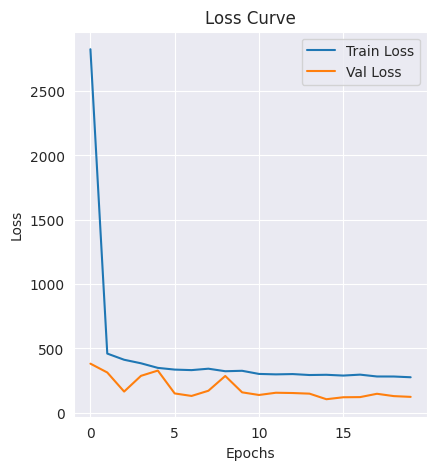

In [23]:
history_data = history.get()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_data["train_loss"], label="Train Loss")
plt.plot(history_data["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

In [24]:
writer.flush()
writer.close()